![alt text](https://zewailcity.edu.eg/main/images/logo3.png)
### Ezzat Esam Eisawy 201901195
#### SVM soft margin quadratic programming implementation using cvxopt

In [1]:
import pandas as pd
import numpy as np;

%pip install cvxopt  
from cvxopt import matrix
from cvxopt.solvers import qp

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Note: you may need to restart the kernel to use updated packages.


#### Formulating the quadratic programming probelm

##### For Svm we need to maximize : $$ \sum_{n=1}^N \alpha_n  - \frac{1}{2} \sum_{n=1}^N  \sum_{m=1}^N \alpha_n \alpha_m y_n y_m \phi (x_n,x_m)  $$

##### The function of qp in cvxopt takes the form of $$ \frac{1}{2} x^TPx + q^Tx $$ which  needs to be minimized

##### So now we need to minimize $$ -\sum_{n=1}^N \alpha_n  + \frac{1}{2} \sum_{n=1}^N  \sum_{m=1}^N \alpha_n \alpha_m y_n y_m \phi (x_n,x_m)  $$

##### Here , X represents the alphas
$$ x =  \begin{bmatrix} \alpha_1  \\ \vdots \\  \vdots  \\  \alpha_n \end{bmatrix} $$

##### As for $q$ $$ q = - \begin{bmatrix} 1 \dots  \dots 1    \end{bmatrix} $$

##### As for $p$
$$ p = \begin{bmatrix} 
    y_{1}y_{1} \phi (x_1,x_1) & \dots  & y_{N} y_{1} \phi (x_N,x_1) \\
    \vdots & \ddots & \vdots\\
    y_{1}y_{N}  \phi (x_1,x_N)& \dots  & y_{N}y_{N} \phi (x_N,x_N) 
    \end{bmatrix}   $$ 


##### In case for linear kernal , we can get $k$ from 
$$ \phi (x_m ,x_n) =  x_m^T * x_n $$

##### In case of polynomial kernal 
$$ \phi (x_m ,x_n) =  ( 1 + x_m^T * x_n)^d $$

##### In case of rbf kernal  
$$ \phi (x_m ,x_n) =  e^{\frac{-||x_m - x_n||^2}{ k  * \gamma^2}} $$
$k$ is the number of features


#### Next step is the conditions , Our conditions are :
$$ \sum_{n=1}^N \alpha_n  y_n  = 0$$ 

$$ 0 \leq \alpha_n \leq C$$
The conditions for Quadratic programming take the form :
$$Gx \leq h , \\
                Ax = b $$


##### We can now find $A,b ,h,G$ 
$$ A = \begin{bmatrix} 
    y_{1} \dots &
    \dots &
    y_{N}  
    \end{bmatrix} $$
$$ b = 0
$$
For $G ,b$ , we need to seperate the conditions , so we have 
$$  \alpha_n \leq C , \\ -\alpha_n \leq 0 $$ 
SO $G$ becomes
$$ G = \begin{bmatrix} 
    1 & 0  &\dots   & 0  \\ 
    0   &1 &\dots   & 0\\
    \vdots &\ddots  &\ddots &  \vdots  \\
     0& \dots  & 0   & 1  \\ 
     -1 & 0  &\dots   & 0  \\ 
    0   & -1 &\dots   & 0\\
    \vdots &\ddots  &\ddots &  \vdots  \\
     0& \dots  & 0   & -1  \\ 
    \end{bmatrix} _{rows = 2N,cols = N}$$
$h$ becomes
$$h = \begin{bmatrix} C \\ \vdots \\ C \\ 0 \\ \vdots \\0
\end{bmatrix} _{rows =2N  } 
$$


##### And now since we can represent $q , p , A , G ,b$

##### We solve for $\alpha$ and use it to calculate weights and $b$ from 
$$ W = \sum_{n=1}^N \alpha_n x_n y_n$$
we get $b$ from 
$$ b = \frac {\sum_{i \in SV } (y_i - \sum_{j \in SV} (\alpha_j y_j \phi (x_j,x_i)))} {len(SV)} $$ 

#### Building the model

In [2]:
class svm_reg :
    def linear_kernal (self,x1 ,x2) :
        return x1.T@x2
    
    def polynomial_kernel(self,x1, x2):
        return ( x1.T @ x2  +1) ** self.param
    
    def rbf_kernel(self, x1 , x2) :
        return np.exp(- np.linalg.norm(x1 -x2)**2 / (self.nf  * self.param**2)) 
        
    
    def __init__(self,m_type : str = 'linear' , C : float = 6 ,param = 1 ) -> None:
        self.C = C;
        self.param = param
        self.m_type = m_type
        if m_type =='linear' :
            self.kernel = self.linear_kernal
        elif m_type == 'polynomial' :
            self.kernel = self.polynomial_kernel
        elif m_type == 'rbf' :
            self.kernel = self.rbf_kernel
        
    def fit(self,X :np.array, Y : np.array) :  
        ''' Initializes the model and calculates the weights vector and  b '''
        n ,self.nf = X.shape

        K = np.zeros((n, n))  # Initialize k matrix (linear model)
        for i in range(n):
            for j in range(n):
                K[i,j] = self.kernel(X[i] , X[j])
        
        P = matrix(np.outer(Y,Y) * K) # outer product of Y and itself * the k matrix

        q = matrix(-1*np.ones(n))  
        b = matrix(0.0)
        A = matrix(Y*1.0,(1,n))

        g = np.diag(np.ones(n))    # first diagonal matrix (n positive 1)
        g2 = -1* np.diag(np.ones(n)) # second diagonal matrix (n negative 1)
        g = np.concatenate((g,g2),axis=0)   # combine the two matrices vertically
        g = matrix(g)
        
        h = self.C * np.ones(n)     # vector of C
        h2 =  np.zeros(n)      # vector of zeros        
        h= np.concatenate((h.T,h2.T),axis = 0)  # combine vertically
        h = matrix(h)
        
        solution = qp(P, q, g, h, A, b)   # solve for alpha
        
        alphas =  np.ravel(solution['x'])  # Get alphas and combine them into an array
        
        self.w = np.zeros(self.nf)    # calculate W
        for  alpha , y,x in zip(alphas,Y,X) :   
            self.w += alpha *y*x
    
        idxs = alphas > 1e-4
        self.svs_x = X[idxs]
        self.svs_y = Y[idxs]
        self.alphas = alphas[idxs]
        
        # Calculate b
        self.b = np.mean([self.svs_y[i] - sum([alpha * y * self.kernel(x,self.svs_x[i]) 
        for alpha , y ,x in zip(self.alphas , self.svs_y , self.svs_x )] ) for i in range(len(self.svs_x))])
        
    def _predict(self, inpt : np.array)    :
        if self.m_type == 'linear' :
            return self.w@ inpt  + self.b
        else :
            return sum([(alpha*y * self.kernel(sv_x , inpt)) for   alpha,y ,sv_x in zip(self.alphas, self.svs_y , self.svs_x) ]) +self.b
        
    
    def predict(self, inpt : np.array) :  
        ''' takes input vector and calculats the expected scalar result '''
        inpt = np.array(inpt)
        if len(inpt.shape ) == 1 :
            return self._predict(inpt)
        else :
            res = np.zeros(len(inpt)) 
            for i in range(len(inpt)) :
                res[i] = self._predict(inpt[i])
            return res;



In [3]:
class svm_class :
    ''' One vs all classifier , Uses set of svm_reg models for each class in the output '''
    def __init__(self,m_type : str = 'linear' , C : float = 6 ,param = 1 ) -> None:
        self.C = C;
        self.param = param
        self.m_type = m_type
    
    def fit(self, X , Y) :
        classes = set(Y)
        models_dict = dict.fromkeys(classes)
        for cl in classes :
            idxs = (Y== cl)
            Y_modified =-1* np.ones(len(Y))
            Y_modified[idxs] = 1
            models_dict[cl] = svm_reg(m_type= self.m_type ,C = self.C , param= self.param)
            models_dict[cl].fit(X,Y_modified.T)

        self.models_dict = models_dict

    def _predict(self,inpt) :
        results_dict = dict.fromkeys(self.models_dict.keys())
        for cl in  self.models_dict.keys() :
            results_dict[cl] = self.models_dict[cl].predict(inpt)
        
        return max(results_dict, key=results_dict.get)

        

    def predict(self,inpt) :
        inpt = np.array(inpt)
        if len(inpt.shape ) == 1 :
            self._predict(inpt)
        else :
            res = np.zeros(len(inpt)) 
            for i in range(len(inpt)) :
                res[i] = self._predict(inpt[i])
            return res;  

#### Testing the model on an actual dataset

In [63]:
#path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data'
path = 'ionosphere.data'
data = pd.read_csv(path ,header= None);
data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [64]:
input_data = data.iloc[:,0:34].copy()
output_data = data.iloc[:,34].copy()
output_data.replace('g',1 ,inplace=True)
output_data.replace('b',-1 ,inplace=True)
output_data

0      1
1     -1
2      1
3     -1
4      1
      ..
346    1
347    1
348    1
349    1
350    1
Name: 34, Length: 351, dtype: int64

In [65]:
input_train ,input_test , output_train , output_test = train_test_split(input_data , output_data , test_size=1/5, shuffle = 1, random_state=50)

#### Training our model

In [66]:
C = 1000
gamma = 0.1
model = svm_class(m_type='rbf' , C= C ,param= gamma)

x = np.array(input_train)
y = np.array(output_train)
model.fit(x,y)


     pcost       dcost       gap    pres   dres
 0:  1.3679e+07 -9.9398e+07  1e+08  8e-02  3e-13
 1:  5.5812e+06 -9.7640e+06  2e+07  8e-03  1e-12
 2:  9.0906e+05 -1.2014e+06  2e+06  6e-14  1e-13
 3:  1.3044e+05 -1.5679e+05  3e+05  2e-13  5e-14
 4:  1.7932e+04 -2.2849e+04  4e+04  5e-14  2e-14
 5:  2.2235e+03 -3.5833e+03  6e+03  6e-15  8e-15
 6:  1.5489e+02 -6.6173e+02  8e+02  2e-14  3e-15
 7: -7.5567e+01 -1.7923e+02  1e+02  6e-15  9e-16
 8: -9.1130e+01 -9.8138e+01  7e+00  9e-16  4e-16
 9: -9.1817e+01 -9.3232e+01  1e+00  8e-15  2e-16
10: -9.2013e+01 -9.2180e+01  2e-01  5e-15  2e-16
11: -9.2050e+01 -9.2060e+01  1e-02  3e-15  1e-16
12: -9.2052e+01 -9.2052e+01  2e-04  6e-15  1e-16
13: -9.2052e+01 -9.2052e+01  3e-06  1e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.3679e+07 -9.9398e+07  1e+08  8e-02  3e-13
 1:  5.5812e+06 -9.7640e+06  2e+07  8e-03  1e-12
 2:  9.0906e+05 -1.2014e+06  2e+06  6e-14  1e-13
 3:  1.3044e+05 -1.5679e+05  3e+05  2e-13  5e-1

#### Testing our model

In [67]:
res_model = model.predict(np.array(input_test))
print('Model accuracy =' , accuracy_score(res_model,output_test) *100)

Model accuracy = 90.14084507042254


#### Testing multiclass classifer on 2d data


In [68]:
name = 'Spiral.txt'
data2d = np.loadtxt(name ,skiprows=7)
x = data2d[:,0:2] 
y = data2d[:,2]


In [69]:
model2d = svm_class(m_type='rbf' ,C= 20 , param = 2)
model2d.fit(x,y)

     pcost       dcost       gap    pres   dres
 0:  4.2366e+03 -2.0900e+04  3e+04  7e-14  8e-15
 1:  7.7498e+02 -1.8694e+03  3e+03  9e-14  8e-15
 2:  7.4501e+01 -2.1233e+02  3e+02  3e-14  4e-15
 3: -1.1944e+01 -5.0246e+01  4e+01  2e-15  1e-15
 4: -1.8644e+01 -2.3210e+01  5e+00  1e-14  4e-16
 5: -1.8986e+01 -2.0176e+01  1e+00  6e-15  2e-16
 6: -1.9111e+01 -1.9658e+01  5e-01  6e-16  1e-16
 7: -1.9168e+01 -1.9370e+01  2e-01  1e-15  1e-16
 8: -1.9202e+01 -1.9269e+01  7e-02  8e-16  2e-16
 9: -1.9213e+01 -1.9240e+01  3e-02  3e-15  2e-16
10: -1.9219e+01 -1.9223e+01  4e-03  3e-15  2e-16
11: -1.9220e+01 -1.9221e+01  4e-04  4e-15  2e-16
12: -1.9220e+01 -1.9220e+01  2e-05  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.2458e+03 -2.0976e+04  3e+04  7e-14  8e-15
 1:  7.7318e+02 -1.8517e+03  3e+03  1e-13  8e-15
 2:  7.4220e+01 -2.1103e+02  3e+02  2e-14  4e-15
 3: -1.1879e+01 -5.0012e+01  4e+01  1e-14  1e-15
 4: -1.8597e+01 -2.2640e+01  4e+00  2e-15  4e-1

In [28]:
import matplotlib.pyplot as plt
def scatter_draw_classifier(classifer ,train_x , name = 'Spiral.txt',n = 50) :
    min_x1 = min(train_x[:,0]) 
    max_x1 = max(train_x[:,0]) 
    min_x2 = min(train_x[:,1]) 
    max_x2 = max(train_x[:,1]) 
    x1 = np.linspace(min_x1, max_x1 , n )
    x2 = np.linspace(min_x2, max_x2 , n )
    xx1, xx2 = np.meshgrid(x1,x2)
    x = np.array((xx1.ravel() , xx2.ravel())).T
    #colors = np.array(["red","green","blue","yellow","pink","black","orange","purple","beige","brown","gray","cyan","magenta" ,'coral'])
    results = classifer.predict(x)
    results_set = set(results)
    plt.figure()
    for i , tp in enumerate(results_set) :
        idxs = results == tp
        plt.scatter(x[idxs,0] , x[idxs,1]  ,label=tp)
    plt.legend()
    plt.title( name +' dataset \n'+ 'Model type :' + classifer.m_type +' C =' + str(round(classifer.C ,1)) + ' Parameter = ' + str(round(classifer.param,3)))
    plt.show()

##### Plotting dicision regions

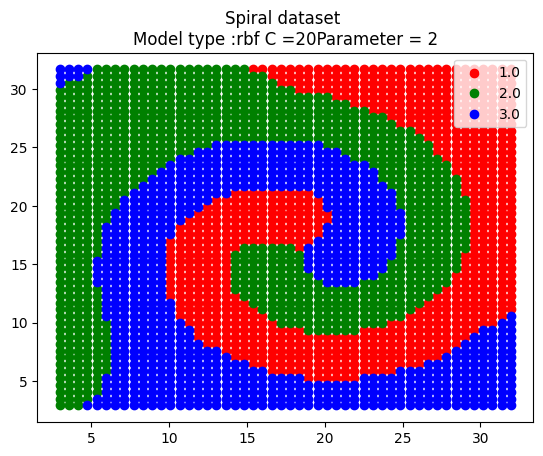

In [72]:
scatter_draw_classifier(model2d,x)

In [19]:
name = 'Flame.txt'
data2d = np.loadtxt(name ,skiprows=7)
x = data2d[:,0:2] 
y = data2d[:,2]
model2d = svm_class(m_type='rbf' ,C= 20 , param = 6)
model2d.fit(x,y)

     pcost       dcost       gap    pres   dres
 0:  1.2301e+03 -2.7900e+04  5e+04  2e-01  2e-14
 1:  1.1429e+03 -3.5872e+03  6e+03  2e-02  2e-14
 2:  2.4738e+02 -9.5786e+02  1e+03  3e-03  1e-14
 3:  3.2812e+01 -5.4245e+02  6e+02  1e-03  1e-14
 4: -1.8411e+01 -4.2703e+02  4e+02  5e-04  8e-15
 5: -9.9195e+01 -3.0335e+02  2e+02  6e-05  1e-14
 6: -1.2990e+02 -2.2477e+02  1e+02  2e-05  9e-15
 7: -1.4427e+02 -2.0892e+02  6e+01  8e-06  1e-14
 8: -1.5313e+02 -1.8645e+02  3e+01  2e-06  1e-14
 9: -1.5700e+02 -1.7965e+02  2e+01  1e-06  1e-14
10: -1.5896e+02 -1.7620e+02  2e+01  5e-07  1e-14
11: -1.6392e+02 -1.6905e+02  5e+00  1e-07  1e-14
12: -1.6609e+02 -1.6623e+02  1e-01  3e-09  1e-14
13: -1.6615e+02 -1.6615e+02  3e-03  4e-11  1e-14
14: -1.6615e+02 -1.6615e+02  4e-05  5e-13  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.2301e+03 -2.7900e+04  5e+04  2e-01  2e-14
 1:  1.1429e+03 -3.5872e+03  6e+03  2e-02  2e-14
 2:  2.4738e+02 -9.5786e+02  1e+03  3e-03  1e-1

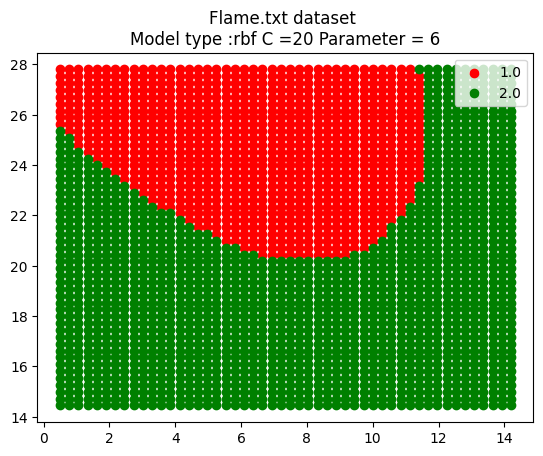

In [23]:
scatter_draw_classifier(model2d,x ,name)

In [ ]:
name = 'R15.txt'
data2d = np.loadtxt(name ,skiprows=7)
x = data2d[:,0:2] 
y = data2d[:,2]
model2d = svm_class(m_type='rbf' ,C= 20 , param = 6)
model2d.fit(x,y)


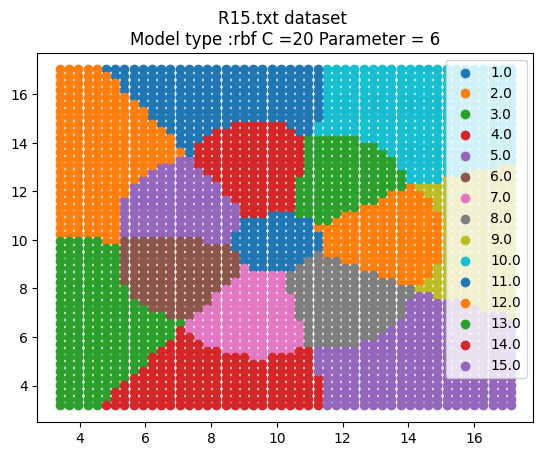

In [30]:
scatter_draw_classifier(model2d, x,name)

In [ ]:
name = 'Pathbased.txt'
data2d = np.loadtxt(name ,skiprows=7)
x = data2d[:,0:2] 
y = data2d[:,2]
model2d = svm_class(m_type='rbf' ,C= 20 , param = 6)
model2d.fit(x,y)


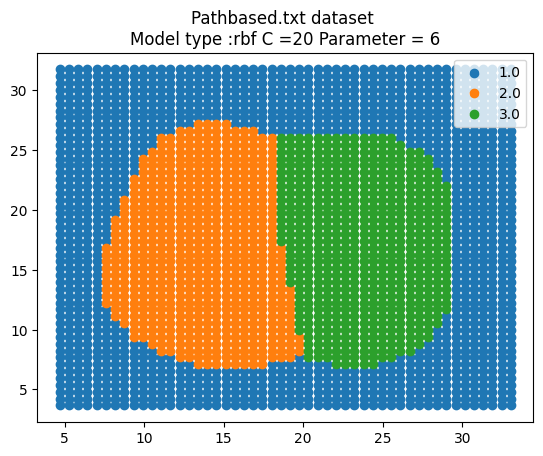

In [32]:
scatter_draw_classifier(model2d, x,name)

     pcost       dcost       gap    pres   dres
 0:  2.0060e+03 -3.2840e+04  5e+04  1e-01  2e-14
 1:  1.0051e+03 -4.7322e+03  7e+03  1e-02  3e-14
 2:  1.5443e+02 -1.2287e+03  2e+03  2e-03  2e-14
 3: -8.9236e+01 -5.8051e+02  5e+02  6e-04  2e-14
 4: -1.5646e+02 -4.9774e+02  3e+02  3e-04  1e-14
 5: -2.0354e+02 -4.0128e+02  2e+02  1e-04  1e-14
 6: -2.3196e+02 -3.4244e+02  1e+02  6e-05  2e-14
 7: -2.4410e+02 -3.1447e+02  7e+01  2e-05  1e-14
 8: -2.5709e+02 -2.8364e+02  3e+01  7e-06  1e-14
 9: -2.6220e+02 -2.7409e+02  1e+01  8e-07  2e-14
10: -2.6477e+02 -2.6937e+02  5e+00  3e-07  1e-14
11: -2.6544e+02 -2.6833e+02  3e+00  9e-08  1e-14
12: -2.6641e+02 -2.6695e+02  5e-01  1e-08  2e-14
13: -2.6663e+02 -2.6665e+02  2e-02  9e-11  2e-14
14: -2.6664e+02 -2.6664e+02  2e-04  9e-13  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1329e+03 -4.0990e+04  8e+04  3e-01  2e-14
 1:  7.8741e+02 -5.5306e+03  9e+03  2e-02  2e-14
 2:  1.8582e+02 -1.4962e+03  2e+03  4e-03  2e-1

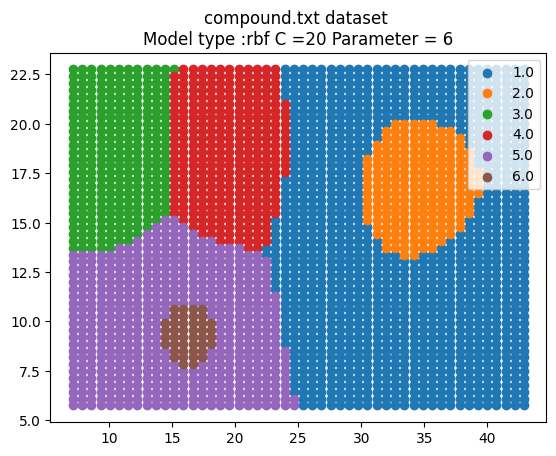

In [33]:
name = 'compound.txt'
data2d = np.loadtxt(name ,skiprows=7)
x = data2d[:,0:2] 
y = data2d[:,2]
model2d = svm_class(m_type='rbf' ,C= 20 , param = 6)
model2d.fit(x,y)
scatter_draw_classifier(model2d, x,name)